# Product based on a Deep Learning model (by fastai v2)
> **Use case**: Dog & Cat Breeds Recognizer for Veterinary Clinics

- **Author**: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou) (AI Professor at the University of Basilia (UnB) & [AI Lab](https://ailab.unb.br/) Associate Researcher in NLP)
- **Date**: 10/22/2020 
- **Post in Medium**: [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c)
- [Github folder](https://github.com/piegu/petsbreeds_voila) of the Web App v1
- [Version 1 of the Web App](https://mybinder.org/v2/gh/piegu/petsbreeds_voila/master?urlpath=%2Fvoila%2Frender%2Fpets_classifier.ipynb)

## Overview

This is the notebook of the post [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c). 

Read this post to understand the context and objective of this notebook.

## 1. Initialization

In [1]:
# Import fastai v2 for computer vision
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
# Check for CUDA & GPU
if torch.cuda.is_available():
    print(f'gpu: {torch.cuda.current_device()} ({torch.cuda.get_device_name()})')

gpu: 0 (Tesla V100-PCIE-32GB)


## 2. Data

In [3]:
# Get path to data
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/mnt/home/pierre/.fastai/data/oxford-iiit-pet/annotations'),Path('/mnt/home/pierre/.fastai/data/oxford-iiit-pet/images')]

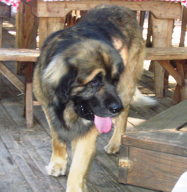

In [4]:
# Check first image
path_to_img = (path/'images').ls()[0]
img = PILImage.create(path_to_img)
img.to_thumb(192)

## 3. Dataloaders

We will define a `DataBlock()` object using all the recent techniques (see the notebook [07_sizing_and_tta.ipynb](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)):
- **Data Augmentation** with the list of transforms at batch level (`aug_transforms()`).
- **Presizing** (notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).
- **Normalization** with the standard ImageNet mean and standard deviation (`Normalize.from_stats(*imagenet_stats)`).
- **Progressive Resizing**: Gradually using larger and larger images as you train (`get_dls()`).

In [5]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                       item_tfms=Resize(460),
                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path/"images", bs=bs)

In [6]:
# Get Dataloaders
dls = get_dls(128, 128)

In [7]:
# Check number of categories and list
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

(128, None)

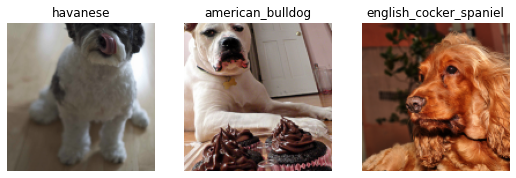

In [8]:
# Batch size and Check images in training batch
dls.bs, dls.show_batch(nrows=1, ncols=3)

## 4. First model (baseline)

To encourage our model to be less confident, we'll use `label smoothing` that will make our training more robust, even if there is mislabeled data. The result will be a model that generalizes better (see the notebook [07_sizing_and_tta.ipynb](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)).

Let's train our model with the following fine-tuning techniques:
- **gradual unfreezing** of layers from the last one to the first ones.
- **Discriminative Learning Rates** (notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).
- **Deeper Architectures**: let's start with resnet34 as baseline, and then resnet152 as final model.

### 4.1 Images of size 128

In [9]:
# Learner with model resnet34
dls = get_dls(128, 128)
model = resnet34
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])

#### Freeze all layers but the last (new) one

In [10]:
# Check model and frozen layers
learn.freeze()
learn.summary()

Sequential (Input shape: ['128 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 64 x 64 x 64   9,408      False     
________________________________________________________________
BatchNorm2d          128 x 64 x 64 x 64   128        True      
________________________________________________________________
ReLU                 128 x 64 x 64 x 64   0          False     
________________________________________________________________
MaxPool2d            128 x 64 x 32 x 32   0          False     
________________________________________________________________
Conv2d               128 x 64 x 32 x 32   36,864     False     
________________________________________________________________
BatchNorm2d          128 x 64 x 32 x 32   128        True      
________________________________________________________________
ReLU                 128 x 64 x 32 x 32   0          False     
________________________________________________

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0063095735386013985)

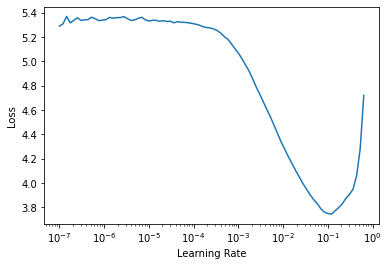

In [11]:
# Learning rate
learn.lr_find()

As only the last layer is unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [12]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,2.204725,1.470944,0.784844,00:10


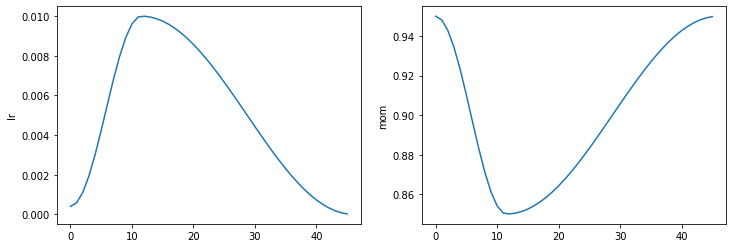

In [13]:
# Display the Learning rate and momentum values used in training
learn.recorder.plot_sched()

In [14]:
# Save the model
learn.save('petbreeds_1')

Path('models/petbreeds_1.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [15]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_1')
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['128 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 64 x 64 x 64   9,408      True      
________________________________________________________________
BatchNorm2d          128 x 64 x 64 x 64   128        True      
________________________________________________________________
ReLU                 128 x 64 x 64 x 64   0          False     
________________________________________________________________
MaxPool2d            128 x 64 x 32 x 32   0          False     
________________________________________________________________
Conv2d               128 x 64 x 32 x 32   36,864     True      
________________________________________________________________
BatchNorm2d          128 x 64 x 32 x 32   128        True      
________________________________________________________________
ReLU                 128 x 64 x 32 x 32   0          False     
________________________________________________

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.5848931980144698e-06)

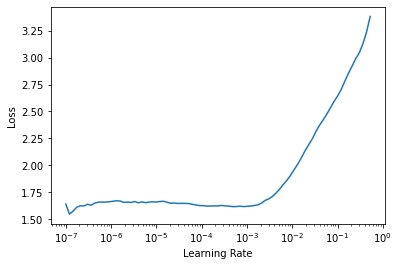

In [16]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (1e-3)**.

In [17]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.586308,1.320002,0.826116,00:10
1,1.473428,1.220881,0.859269,00:10
2,1.371713,1.193700,0.859269,00:10
3,1.261236,1.140758,0.875507,00:10
4,1.173585,1.123551,0.864682,00:10
5,1.091030,1.078906,0.887010,00:10
6,1.032797,1.059132,0.889039,00:10
7,0.986927,1.048918,0.886333,00:10
8,0.962747,1.043976,0.889039,00:10
9,0.949135,1.042742,0.893099,00:10


Baseline model accuracy: **89.31%**

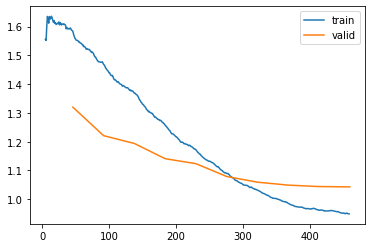

In [18]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [19]:
# Save the model
learn.save('petbreeds_2')

Path('models/petbreeds_2.pth')

### 4.2 Images of size 224

In [20]:
# Learner with model resnet34
dls = get_dls(64, 224)
model = resnet34
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_2')

#### Freeze all layers but the last (new) one

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=7.585775847473997e-07)

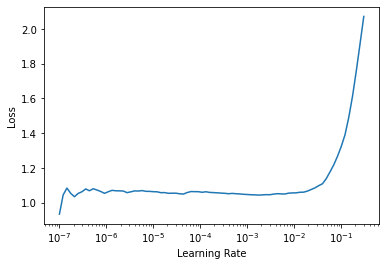

In [21]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layer is unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (2e-4)**.

In [22]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.036574,0.962142,0.933694,00:14


In [23]:
# Save the model
learn.save('petbreeds_3')

Path('models/petbreeds_3.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [24]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_3')
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

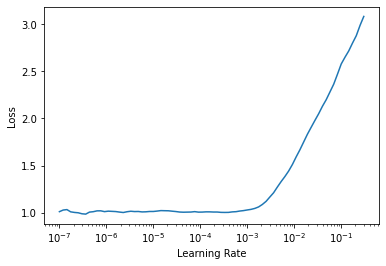

In [25]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-4)**.

In [26]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.021168,0.951557,0.935724,00:17
1,0.992551,0.934461,0.940460,00:16
2,0.953975,0.922366,0.936401,00:16
3,0.931800,0.914601,0.937754,00:17
4,0.906766,0.901651,0.947903,00:16
5,0.890850,0.902056,0.944520,00:17
6,0.878638,0.889122,0.945196,00:16
7,0.869708,0.884780,0.946549,00:17
8,0.868199,0.881976,0.951962,00:17
9,0.866460,0.882781,0.948579,00:16


In [77]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9539918899536133

Baseline model accuracy: **95.40%**

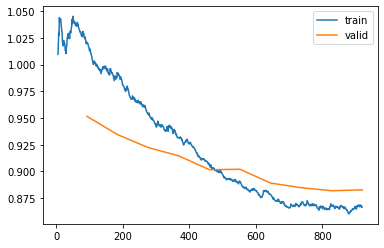

In [27]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [28]:
# Save the model
learn.save('petbreeds_4')

Path('models/petbreeds_4.pth')

## 5. Results analysis

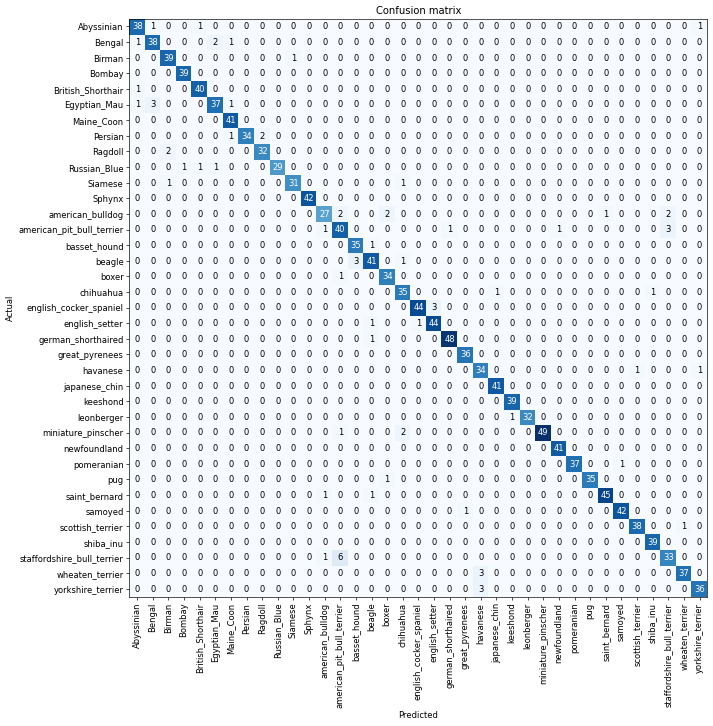

In [41]:
# Load model and display the Confusion Matrix
learn = learn.load('petbreeds_4')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
# Get categories with the most errors
interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('beagle', 'basset_hound', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('wheaten_terrier', 'havanese', 3),
 ('yorkshire_terrier', 'havanese', 3)]

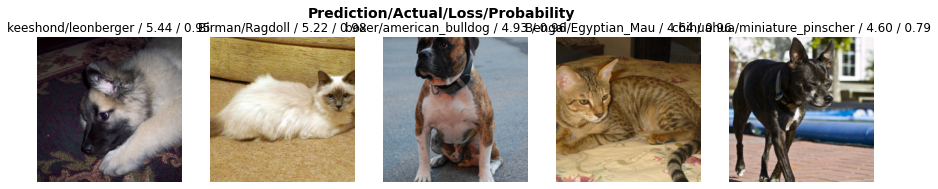

In [43]:
# Get the images with highest loss between prediction and true category
interp.plot_top_losses(5, nrows=1)

In [44]:
# Clean training and validation datasets
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## 6. Deeper model

### 6.1 Images of size 128

In [45]:
# Learner with model resnet152
dls = get_dls(128, 128)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])

#### Freeze all layers but the last (new) one

In [46]:
# Check model and frozen layers
learn.freeze()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0008317637839354575)

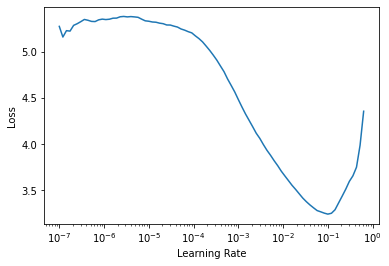

In [47]:
# Learning rate
learn.lr_find()

As only the last layer is unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [48]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.984388,1.491735,0.803789,00:20


In [49]:
# Save the model
learn.save('petbreeds_5')

Path('models/petbreeds_5.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [50]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_5')
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.0964781722577754e-06)

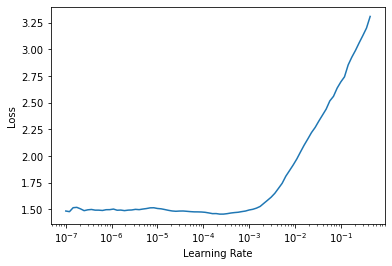

In [51]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-4)**.

In [52]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.473513,1.302816,0.835589,00:25
1,1.405306,1.215646,0.861299,00:25
2,1.318926,1.170392,0.866712,00:24
3,1.234848,1.132229,0.886333,00:24
4,1.175394,1.110505,0.890392,00:24
5,1.127627,1.087428,0.896482,00:25
6,1.090511,1.086275,0.897158,00:24
7,1.065642,1.078029,0.895805,00:25
8,1.045674,1.075211,0.897835,00:24
9,1.035725,1.071048,0.897835,00:25


Deeper model accuracy: **89.78%**

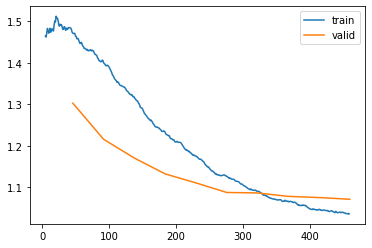

In [53]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [54]:
# Save the model
learn.save('petbreeds_6')

Path('models/petbreeds_6.pth')

### 6.2 Images of size 224

In [55]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_6')

#### Freeze all layers but the last (new) one

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.5848931980144698e-06)

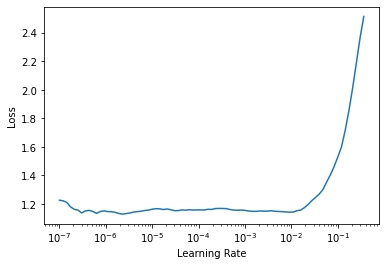

In [56]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layer is unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-3)**.

In [58]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
learn.fit_one_cycle(1, lr_max=lr_max)

epoch,train_loss,valid_loss,accuracy,time
0,1.070695,0.979857,0.931664,00:43


In [59]:
# Save the model
learn.save('petbreeds_7')

Path('models/petbreeds_7.pth')

#### Unfreeze all layers and Discriminative Learning Rates

In [60]:
# Load model, unfreeze layers and check it
learn = learn.load('petbreeds_7')
learn.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=1.5848931980144698e-06)

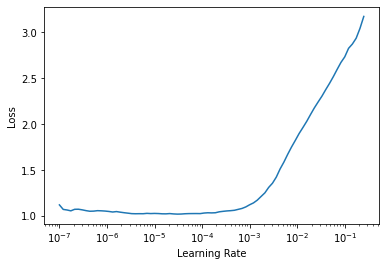

In [61]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-5)**.

In [62]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-5
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.017913,0.970047,0.935047,00:56
1,1.026601,0.959922,0.934371,00:56
2,1.014295,0.955836,0.938430,00:56
3,0.989764,0.949453,0.939107,00:56
4,0.990386,0.946892,0.939784,00:56
5,0.976985,0.943799,0.939784,00:55
6,0.987667,0.940762,0.940460,00:56
7,0.974066,0.947678,0.940460,00:56
8,0.969518,0.941596,0.939107,00:55
9,0.960903,0.940221,0.941813,00:56


In [75]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9492557644844055

Deeper model accuracy: **94.92%**. Within our dataset, the use of a Deeper model does not help (accuracy of our baseline model: 95.4%). 

Let's test regularization techniques in the following paragraph.

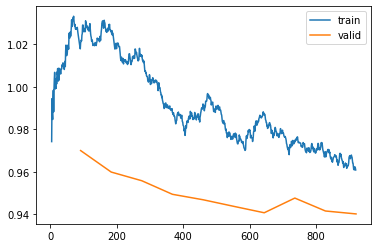

In [63]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [64]:
# Save the model
learn.save('petbreeds_8')

Path('models/petbreeds_8.pth')

## 7. Deeper model with regularisation

In [65]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('petbreeds_7')

### Dropout

In [66]:
# The model has already a value of 50% of dropout
learn.model[1][7]

Dropout(p=0.5, inplace=False)

### Weight Decay

In [67]:
# Load model, unfreeze layers and check it
learn.unfreeze()
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [68]:
# let's increase weight decay from 0.01 to 0.1
wd = 0.1
learn.opt_func = partial(Adam, sqr_mom=0.99, eps=1e-05, wd=wd, decouple_wd=True)
learn.opt_func

functools.partial(<function Adam at 0x7f84dc655670>, sqr_mom=0.99, eps=1e-05, wd=0.1, decouple_wd=True)

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.5848931980144698e-06)

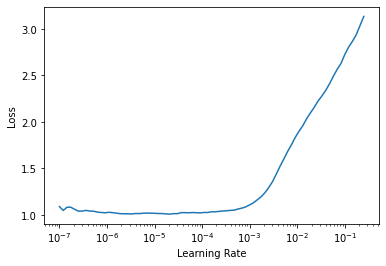

In [69]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-5)**.

In [70]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-5
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,1.027706,0.971606,0.931664,00:56
1,1.007818,0.957255,0.935724,00:55
2,0.993733,0.956846,0.937754,00:56
3,0.983502,0.947544,0.941813,00:56
4,0.989188,0.952140,0.937077,00:56
5,0.981377,0.945588,0.937754,00:56
6,0.976960,0.943102,0.937077,00:56
7,0.974034,0.940747,0.935724,00:56
8,0.970089,0.941225,0.937077,00:56
9,0.965893,0.938787,0.939784,00:56


In [74]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9465494155883789

The accuracy did not improve. **The thing to do to improve it is certainly to get more training data ... as always with Deep Learning models!**

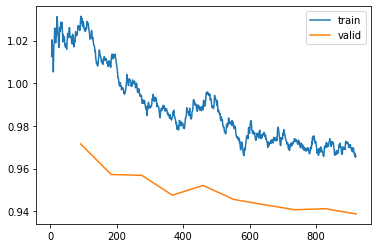

In [71]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [72]:
# Save the model
learn.save('petbreeds_9')

Path('models/petbreeds_9.pth')

## 8. Export best model

According to the accuracy, **we keep our baseline model as the best one with a validation accuracy of 95.4%**.

In [95]:
# Export best model
learn = learn.load('petbreeds_4')
learn.export()

## 9. Turning your model into a Web App

Fonte: notebook [02_production.ipynb](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)

In [79]:
# Get model for inference
learn_inf = load_learner('export.pkl')

### Creating a notebook App from the model

In [80]:
# Button to upload image
btn_upload = widgets.FileUpload()

# Button to classify
btn_run = widgets.Button(description='Classify')

# Display a thumb of the image
out_pl = widgets.Output()
out_pl.clear_output()

# Calculation and display of the category prediction
lbl_pred = widgets.Label()
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [81]:
# Run app
VBox([widgets.Label('Select your animal!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a (real) Web App

fastai explains in the notebook [02_production.ipynb](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) how to create a Web App using your `export.pkl` file on a free Web service like [Binder](https://mybinder.org/) + [Voilà](https://voila.readthedocs.io/en/stable/using.html). You can as well read and apply this [Guide on how to duplicate the fastai bear_voila app on Binder](https://forum.ailab.unb.br/t/binder-and-fastai2/90/2) (if you need help about git, read this [git - the simple guide](https://rogerdudler.github.io/git-guide/)).

This is a great way for your first *well-chosen users* (parents or friends for example, or even a first client) to use your Web App, which will give you initial feedback and new data, which in turn will allow you to improve both your model and your Web App interface (this is *The Virtuous Cycle of AI* of Andrew Ng explained in the [AI Transformation Playbook](https://landing.ai/ai-transformation-playbook/)).

Of course, this free service is not sufficient for a professional Web App that you are going to develop alongside this first version. 

To do that, check the following paragraph for tips and have fun!

**Version 1 of our "Dog & Cat Breeds Recognizer for Veterinary Clinics"**
- Github: https://github.com/piegu/petsbreeds_voila
- Web App: https://mybinder.org/v2/gh/piegu/petsbreeds_voila/master?urlpath=%2Fvoila%2Frender%2Fpets_classifier.ipynb

![](https://raw.githubusercontent.com/piegu/petsbreeds_voila/master/images/webapp_v1.png)

## 10. Turning your Web App into a startup product

This paragraph is written in the post [Product based on a Deep Learning model (by fastai v2)](https://medium.com/@pierre_guillou/product-based-on-a-deep-learning-model-by-fastai-v2-8bd3371ba11c). 

## End of the notebook but about our startup product: to be continued...